In [1]:
from  keras  import  applications
from  keras.preprocessing.image  import  ImageDataGenerator 
from keras.optimizers import SGD
from  keras.models  import  Sequential,  Model
from  keras.applications.vgg16 import VGG16 
from  keras.layers  import  Dropout,  Flatten,  Dense, Input 
top_model_weights_path  =  'VGG16_FE_model_1.h5'

img_width = 224
img_height = 224

nb_epochs = 30
batch_size  =  64  #  reduce  to  5  in  order  to  be  able  to  compute  the  calcs

train_dir  =  "balanced_dataset/train" 
validation_dir = "balanced_dataset/validation" 
test_dir  =  "balanced_dataset/test"

nb_train = 4000
nb_validation = 1200
nb_test = 1200
nb_classes = 4


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_tensor = Input(shape=(img_width, img_height, 3))  #  another  way  to  shape  the  input

base_model = applications.VGG16(
    weights='imagenet',  
    include_top=False, 
    input_tensor=input_tensor)

In [3]:
# top model
top_model = Sequential() 
top_model.add(Flatten(input_shape=base_model.output_shape[1:])) 
top_model.add(Dense(256,  activation='relu')) 
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes,  activation='softmax'))

# base model has its weights, now we load the weights on the top layer 
top_model.load_weights("VGG/VGG16_FE_model_1.h5")

# we join base and top it has to be updated to api2
model_total  =  Model(input = base_model.input,  output = top_model(base_model.output))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  if sys.path[0] == '':


In [15]:
model_total.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
#  sequential  is  the  top  layer  a  complex  one 
for i, layer in enumerate(model_total.layers):
    print  (i, layer.name, layer.output_shape)

for i, layer in enumerate(model_total.layers): 
    if  layer.trainable:
        print("layer {0:d},{1:s} is trainable".format(i, layer.name)) 
    else:
        print("layer {0:d},{1:s} is freezed".format(i, layer.name))

# freezing layers implies they will not update their weights over the training 
for  layer  in  model_total.layers[:4]: #15
    layer.trainable = False

# check for updates
for i, layer  in enumerate(model_total.layers): 
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name)) 
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))


0 input_1 (None, 224, 224, 3)
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 sequential_1 (None, 4)
layer 0,input_1 is freezed
layer 1,block1_conv1 is freezed
layer 2,block1_conv2 is freezed
layer 3,block1_pool is freezed
layer 4,block2_conv1 is freezed
layer 5,block2_conv2 is freezed
layer 6,block2_pool is freezed
layer 7,block3_conv1 is freezed
layer 8,block3_conv2 is freezed
layer 9,block3_conv3 is 

In [7]:
#PREPROCESSING + DATA AUGMENTATION
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip  =  True, 
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory( 
    train_dir, 
    target_size=(img_width,img_height), 
    batch_size=batch_size, 
    class_mode='categorical')

test_datagen  =  ImageDataGenerator(rescale=1. / 255)  #  not  in  the  val  data 

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='categorical')


Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [8]:
#Compile model
model_total.compile(optimizer=SGD(lr=1e-4,  momentum=0.9), 
                    loss='categorical_crossentropy',  
                    metrics=['accuracy'])

In [9]:
#Fit model
history = model_total.fit_generator( 
    train_generator, 
    samples_per_epoch=nb_train, 
    epochs=nb_epochs,
    verbose  =  1, 
    validation_data=validation_generator, 
    validation_steps=nb_validation)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=1, validation_data=<keras.pre..., validation_steps=1200, epochs=30, steps_per_epoch=62)`
  


Epoch 1/30
62/62 [==============================] - 620s 10s/step - loss: 0.9436 - acc: 0.6318 - val_loss: 0.5477 - val_acc: 0.7835
Epoch 2/30
62/62 [==============================] - 617s 10s/step - loss: 0.7042 - acc: 0.7160 - val_loss: 0.4777 - val_acc: 0.8050
Epoch 3/30
62/62 [==============================] - 621s 10s/step - loss: 0.6400 - acc: 0.7470 - val_loss: 0.4507 - val_acc: 0.8268
Epoch 4/30
62/62 [==============================] - 618s 10s/step - loss: 0.6140 - acc: 0.7548 - val_loss: 0.4281 - val_acc: 0.8125
Epoch 5/30
62/62 [==============================] - 617s 10s/step - loss: 0.5893 - acc: 0.7689 - val_loss: 0.4638 - val_acc: 0.8191
Epoch 6/30
62/62 [==============================] - 617s 10s/step - loss: 0.5486 - acc: 0.7921 - val_loss: 0.3929 - val_acc: 0.8442
Epoch 7/30
62/62 [==============================] - 615s 10s/step - loss: 0.5589 - acc: 0.7765 - val_loss: 0.3973 - val_acc: 0.8468
Epoch 8/30
62/62 [==============================] - 614s 10s/step - loss: 0.

In [10]:
model_total.save_weights('VGG/VGG16_FT_model_1.h5')

In [11]:
def print_graphics (history):
    import  matplotlib.pyplot  as  plt
    #Mostramos otro tipo de grafico
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.tittle('Trainning and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    #plt.tittle('Trainning and validation loss')
    plt.legend()

    plt.show()

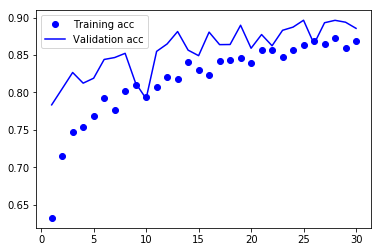

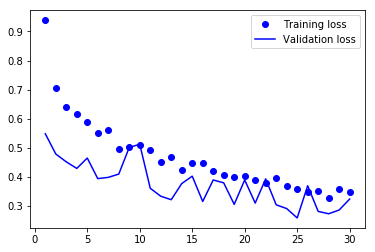

In [13]:
print_graphics (history)

In [14]:
model_total.evaluate_generator(test_generator)

[0.3376823564370473, 0.875833334128062]

In [20]:
#Borrar
import math
import numpy as np 
import os

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width,img_height), 
    batch_size=batch_size,
    shuffle  =False, 
    class_mode='categorical')

steps = int(math.ceil(nb_test / batch_size))

(loss, acc) = model_total.evaluate_generator(test_generator, steps=steps) 
print("acc:  {0:.2f}%  -  loss:  {1:f}".format(acc  *  100,  loss))
predictions = model_total.predict_generator(test_generator, steps = steps) 
from  sklearn.metrics  import  confusion_matrix

#################
      
PATH_TO_IMG  =  "VGG"

prediction_list = [] 
real_label_list = []
 
cat_dict  =  test_generator.class_indices  #  the  key  attribute
inverse_coding  =  {value:  key  for  key,  value  in  cat_dict.items()}  #  dict  of  categories

for label in test_generator.classes: 
      real_label_list.append(inverse_coding[label])

for  prediction  in  predictions: 
      prediction_list.append(inverse_coding[np.argmax(prediction)])

#  in  order  to  get  the  confusion  matrix
class_names  =  sorted([folder  for  folder  in  os.listdir(PATH_TO_IMG)
    if os.path.isdir(os.path.join(PATH_TO_IMG, folder))]) 
      
prediction_list_arr = np.array(prediction_list)
real_label_list_arr   =   np.array(real_label_list)

VGG16_cm_ft = confusion_matrix(real_label_list_arr,prediction_list_arr)


Found 1200 images belonging to 4 classes.
acc:  87.58%  -  loss:  0.337682


In [21]:
# reference http://scikit- learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
import  itertools
import  matplotlib.pyplot  as  plt

def  plot_confusion_matrix(cm,  classes,  normalize=False,  title='Confusion  matrix', cmap=plt.cm.Blues):
#"""
#This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`. """
    if  normalize:
        cm  =  cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm,  interpolation='nearest',  cmap=cmap) 
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes,  rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if  normalize else 'd' 
    thresh = cm.max() / 2.
    for i, j in  itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j,  i,  format(cm[i, j],  fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True  label',size=20) 
    plt.xlabel('Predicted  label',size=20)

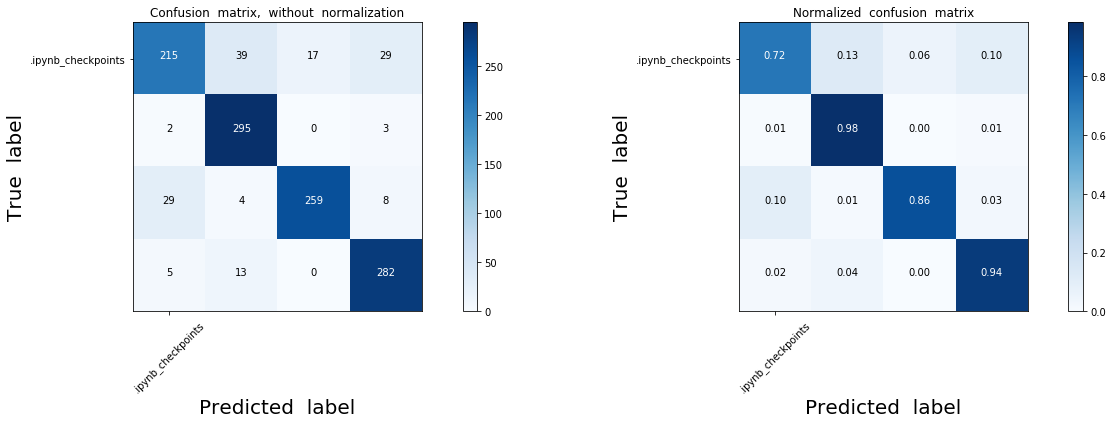

In [22]:
fig  =  plt.figure(figsize=(20, 6)) 
fig.add_subplot(1,2,1) 
      
plot_confusion_matrix(VGG16_cm_ft, classes=class_names, title='Confusion  matrix,  without  normalization') 
      
fig.add_subplot(1,2,2)
plot_confusion_matrix(VGG16_cm_ft, classes=class_names, normalize=True, title='Normalized  confusion  matrix')

plt.show()
